# TALLER 3

Orianna Sanguino Gómez 
201413158

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import string
import matplotlib.cm as cm
import os
from scipy import ndimage

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Datos Llantas tractivas 
rll=0.139 # Radio geométrico de las llantas en traseras (m)
refc=0.98*rll # Radio efectivo llantas traseras (m)
rin=0.0631 #radio interno del neumático (m)

# Datos Transmisión
dp=11.0 # Dientes del piñon
dpl=87.0 # Dientes del plato
ng=dpl/dp # Relación de Transmisión
etaf=0.95 # Eficiencia de transmisión

# Datos eje llantas
reje=0.02 # Radio eje de las llantas (m)
meje=3.832 # Masa del eje (kg)

# Datos Kart general
masa=140.0 # masa del Kart con piloto(kg)
g=9.81 # Gravedad (m/s)
w=masa*g # peso del Kart (N)

# Datos Fuerzas de la fórmula de aceleración
rho=1.1955 # densidad del aire (kg/m^3)
dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
vw=0.0 # velocidad del viento (m/s)
theta=0.0 # Angulo carretera

# Inercias
ii=0.01 # Inercia motor de combustión 

mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)
mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)

rpi=0.01525 # Radio Piñon (m)
rpla=0.10775 # Radio Plato (m)
rhoac=7850.0 # Densidad del Acero (kg/m^3)
bpi=0.01 # Ancho piñon (m)
bpla=0.01 # Ancho plato (m)
vpi= bpi*np.pi*rpi**2 # Volumen del piñon (m^3)
vpla=bpla*np.pi*rpla**2 # Volumen del plato (m^3)
mpi=rhoac*vpi # Masa del piñon (kg)
mpla=rhoac*vpla # Masa del plato (kg)
ig=((mpi*(rpi**2))/2)+((mpla*(rpla**2))/2) # Inercia de la transmisión (kg-m^2)

ieje=(meje*reje**2)/2 # Inercia del eje de las llantas (kg-m^2)

# Fuerzas Aceleración
# Resistencia a la rodadura
a=0.2036 # Distancia del centro de gravedad al eje de la llanta trasera (m)
l=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
h=0.0960 # Altura del centro de gravedad del kart con respecto al piso (m)


In [3]:
def accel(vx, ddt):
    return ndimage.gaussian_filter1d(vx, sigma=20, order=1, mode='wrap') / ddt

In [4]:
def frodadura(vx,ax):
    wr=w*((a/l)+(ax/g*(h/l))) # fuerza vertical sobre las llantas tractivas
    fr=0.01*(1+(vx/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)
    # fr=C*((mllt*g)/(rllt*2))*sqrt(ht/bllt)
    # ht=0.0739 # Altura del neumático (m)
    # bllt=0.209 # Ancho del neumático (m)
    # C= # Constante del material de la llanta
    return wr*fr*cos(theta) # (N)

In [5]:
# Fuerza del ángulo de la carretera
def finclinacion(theta):
    return w*sin(theta) # (N)

In [6]:
# Fuerza de arrastre
def farrastre(vx):
    return (1/2.0)*rho*af*cd*(vx+vw)**2 # (N)

In [7]:
# Fuerza de tracción, Torque del Motor
def ftraccion(ax,Fg,Fw,Fr):
    # Ft=((ti*ng*etaf)/refc)-(((ii-ig)*ng^2)+ieje+illd*2+illt*2)*(ax/(refc^2)) # (N)
    return masa*ax+Fg+Fw+Fr

In [8]:
def torquemotor(ax,Ft):
    return (Ft+(((ii-ig)/(ng**2))+ieje+illd*2+illt*2)*(ax/(refc**2)))*(refc/(ng*etaf)) # Torque del motor (Nm)

In [9]:
# Velocidad angular del motor
def vangularmotor(vx):
    return (vx*ng)/refc # (rad/s)

In [10]:
#Lectura de los datos
def lec_datos(base_dir,data_file):
    with open(os.path.join(base_dir,data_file), 'r') as vboxdata:
        section = []
        time = []
        lat = []
        long = []
        vel = []
        height = []
        #vertv = []
        for line in vboxdata:
            if line[0] == '[':
                section = str.replace(line, "\n","")
                continue
            if section == '[column names]':
                col_names = str.replace(line, "  \n","").split('  ')
                section = []
            if section == '[data]':
                linesplit = str.replace(line, " \n","").split(' ')
                time.append(float(linesplit[1][0:2])*3600+float(linesplit[1][2:4])*60+float(linesplit[1][4:]))
                lat.append(float(linesplit[2]))
                long.append(float(linesplit[3]))
                vel.append(float(linesplit[4]))
                height.append(float(linesplit[6]))
                #vertv.append(float(linesplit[7]))

    time = np.asarray(time)
    lat = np.asarray(lat)
    long = np.asarray(long)
    vel = np.asarray(vel)
    height = np.asarray(height)
    #vertv = np.asarray(vertv)
    time_base = time[0]
    time = time - time_base
    lat = lat/60.0
    long = -long/60.0
    dt = time[1]-time[0]
    return time, lat, long, vel, height, time_base, dt

In [11]:
x = lec_datos('Data','VBOX0019.VBO')
y = lec_datos('data_electrico', 'VBS__047.VBO')

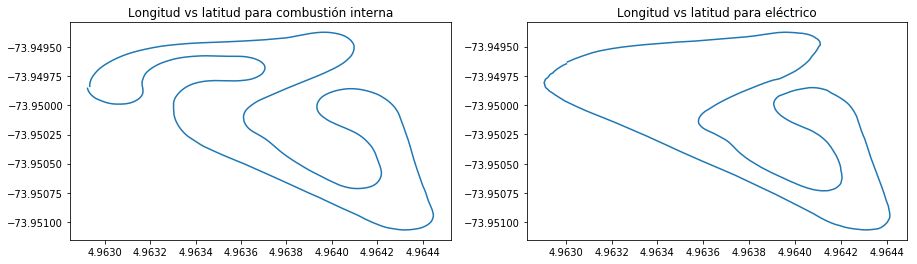

In [12]:
lat_2 = x[1]
long_2 = x[2]
lat = y[1]
long = y[2]
inicio_2 = 350
puntos_2 = 1203
inicio = 15690
puntos = 5570
figure(figsize=(15,4))
plt.subplot(1,2,1)
plot(lat_2[inicio:inicio+puntos],long_2[inicio:inicio+puntos])
plt.title('Longitud vs latitud para combustión interna')
plt.subplot(1,2,2)
plot(lat[inicio_2:inicio_2+puntos_2],long[inicio_2:inicio_2+puntos_2])
plt.title('Longitud vs latitud para eléctrico')
plt.show()

In [13]:
inicio = 15690
puntos = 5570
inicio_2 = 350
puntos_2 = 1160

In [16]:
def graficar(x,y): #x-combustión   y-eléctrico
    #Variables
    t = x[0]
    t_2 = y[0]
    v = x[3]
    v_2 = y[3]
    dt = x[6]
    dt_2 = y[6]
    
    vms = v/3.6
    vms_2 =v_2/3.6
    
    acx = accel(vms[inicio:inicio+puntos],dt)
    acx_2 = accel(vms_2[inicio_2:inicio_2+puntos_2],dt_2)
    
    #Fuerzas
    finc = finclinacion(theta)
    farr = farrastre(vms[inicio:inicio+puntos])
    farr_2 = farrastre(vms_2[inicio_2:inicio_2+puntos_2])
    frod = frodadura(v[inicio:inicio+puntos],acx)
    frod_2 = frodadura(v_2[inicio_2:inicio_2+puntos_2],acx_2)
    ftrac = ftraccion(acx,finc,farr,frod)
    ftrac_2 = ftraccion(acx_2,finc,farr_2,frod_2)
    
    #Torque
    To = torquemotor(acx,ftrac)
    To_2 = torquemotor(acx_2,ftrac_2)
    
    #Velocidad angular
    omegam = vangularmotor(vms[inicio:inicio+puntos])
    omegam_2 = vangularmotor(vms_2[inicio_2:inicio_2+puntos_2])
    
    #Potencia
    Pow = omegam*To/1000
    Pow_2 = omegam_2*To_2/1000
    
    #Gráficas
    #Velocidad
    figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(t[inicio:inicio+puntos],v[inicio:inicio+puntos], '-r') 
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Velocidad [m/s]')
    plt.title('Velocidad vs Tiempo Combustión Interna')
    plt.grid()
    plt.subplot(1,2,2)
    plt.plot(t_2[inicio_2:inicio_2+puntos_2],v_2[inicio_2:inicio_2+puntos_2], '-b')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Velocidad [m/s]')
    plt.title('Velocidad vs Tiempo Eléctrico')
    plt.grid()
    plt.show()
    
    #Aceleración
    figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(t[inicio:inicio+puntos],acx, '-r')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Aceleración [$m/s^2$]')
    plt.title('Aceleración vs Tiempo Combustión Interna')
    plt.grid()
    plt.subplot(1,2,2)
    plt.plot(t_2[inicio_2:inicio_2+puntos_2],acx_2, '-b')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Aceleración [$m/s^2$]')
    plt.title('Aceleración vs Tiempo Eléctrico')
    plt.grid()
    plt.show()
    
    #Fuerzas
    figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(t[inicio:inicio+puntos],ftrac,'-b', label="Fuerza de traccion")
    plt.plot(t[inicio:inicio+puntos],farr,'-y', label="Fuerza de arrastre")
    plt.plot(t[inicio:inicio+puntos],frod,'-r',label="Fuerza de rodadura")
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Fuerzas [N]')
    plt.title('Fuerzas vs Tiempo Combustión Interna')
    plt.grid()
    plt.legend(loc='best')
    plt.subplot(1,2,2)
    plt.plot(t_2[inicio_2:inicio_2+puntos_2],ftrac_2,'-b', label="Fuerza de traccion")
    plt.plot(t_2[inicio_2:inicio_2+puntos_2],farr_2,'-y', label="Fuerza de arrastre")
    plt.plot(t_2[inicio_2:inicio_2+puntos_2],frod_2,'-r',label="Fuerza de rodadura")
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Fuerzas [N]')
    plt.title('Fuerzas vs Tiempo Eléctrico')
    plt.grid()
    plt.legend(loc='best')
    plt.show()
    
    #Torque
    figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(t[inicio:inicio+puntos],To, '-r')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Torque [Nm]')
    plt.title('Torque vs Tiempo Combustión Interna')
    plt.grid()
    plt.subplot(1,2,2)
    plt.plot(t_2[inicio_2:inicio_2+puntos_2],To_2, '-b')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Torque [Nm]')
    plt.title('Torque vs Tiempo Eléctrico')
    plt.grid()
    plt.show()
    
    #Velocidad Angular
    figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(t[inicio:inicio+puntos],omegam*30/np.pi, '-g')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Velocidad angular [rpm]')
    plt.title('Velocidad angular vs Tiempo Combustión Interna')
    plt.grid()
    plt.subplot(1,2,2)
    plt.plot(t_2[inicio_2:inicio_2+puntos_2],omegam_2*30/np.pi, '-r')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Velocidad angular [rpm]')
    plt.title('Velocidad angular vs Tiempo Eléctrico')
    plt.grid()
    plt.show()
    
    #Potencia
    figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(t[inicio:inicio+puntos],omegam*To/1000, '-g')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Potencia [kW]')
    plt.title('Potencia vs Tiempo Combustión Interna')
    plt.grid()
    plt.subplot(1,2,2)
    plt.plot(t_2[inicio_2:inicio_2+puntos_2],omegam_2*To_2/1000, '-r')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Potencia [kW]')
    plt.title('Potencia vs Tiempo Eléctrico')
    plt.grid()
    plt.show()
    
    #Torque vs velocidad angular
    figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(omegam*30/np.pi,To, '-g')
    plt.xlabel('Velocidad angular [rpm]')
    plt.ylabel('Torque [Nm]')
    plt.title('Torque vs velocidad angular Combustión Ineterna')
    plt.grid()
    plt.subplot(1,2,2)
    plt.plot(omegam_2*30/np.pi,To_2, '-r')
    plt.xlabel('Velocidad angular [rpm]')
    plt.ylabel('Torque [Nm]')
    plt.title('Torque vs velocidad angular Eléctrico')
    plt.grid()
    plt.show()

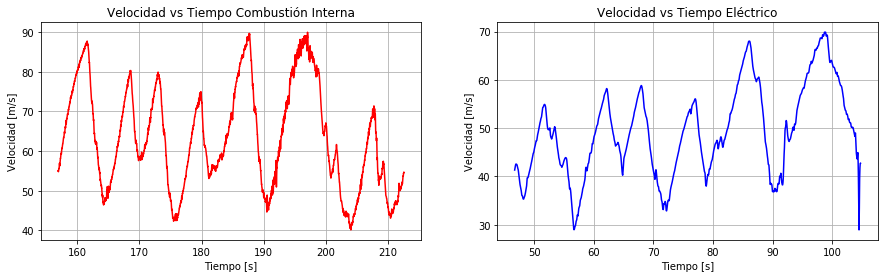

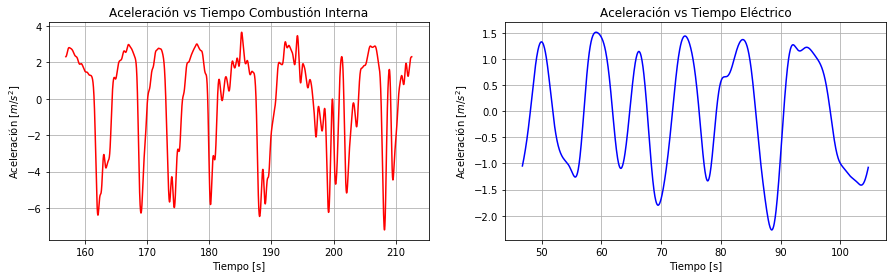

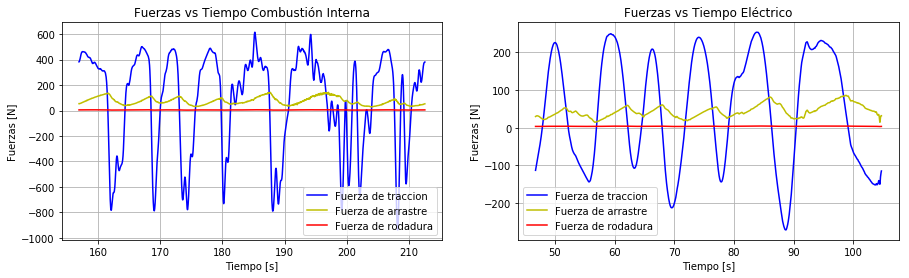

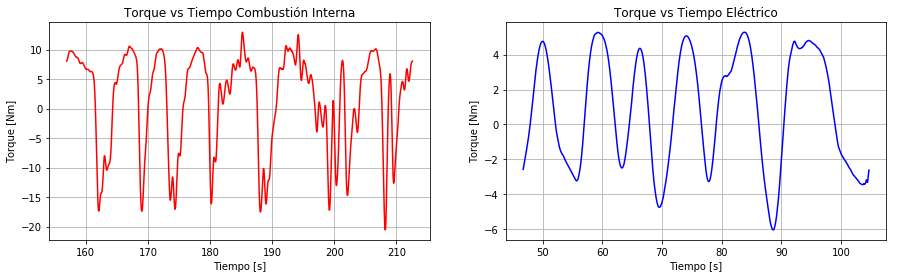

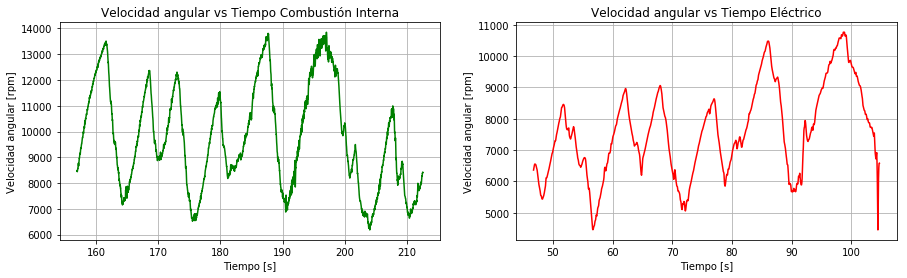

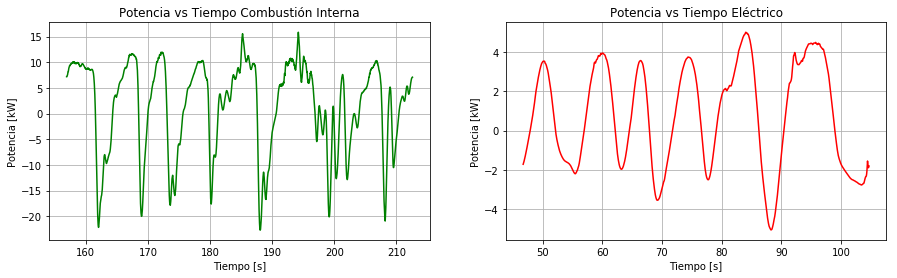

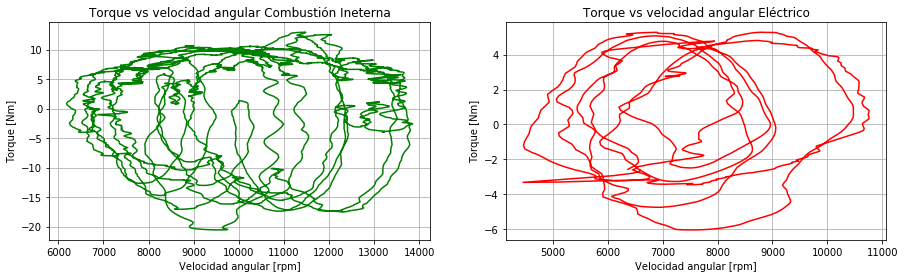

In [17]:
graficar(x,y)